[View in Colaboratory](https://colab.research.google.com/github/byebye/MNIST/blob/master/MNIST.ipynb)

# Install PyTorch

In [2]:
# https://pytorch.org/
!pip3 install torch torchvision

    100% |████████████████████████████████| 484.0MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b73c000 @  0x7f18a472b1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 17.7MB/s 
    100% |████████████████████████████████| 2.0MB 15.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


# Import PyTorch and check CUDA availability

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable

use_cuda = True
if use_cuda:
  assert(torch.cuda.is_available())

# Load Kaggle MNIST dataset from Google Drive

In [0]:
# Install the PyDrive wrapper & import libraries.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_file_id = '12WsWKOlQ-IHlU4jK35xNJ3koG_CL6l5z'
test_file_id = '12MIA-FGEU4Ahtyqd_lDarSF0_cNenOj1'

train_file = drive.CreateFile({'id': train_file_id})
test_file = drive.CreateFile({'id': test_file_id})

test_file.GetContentFile('test.csv')
train_file.GetContentFile('train.csv')

In [0]:
import pandas as pd

kaggle_train_file = pd.read_csv('train.csv', dtype='uint8')
kaggle_test_file = pd.read_csv('test.csv', dtype='uint8')

In [6]:
print(kaggle_train_file.shape)
print(kaggle_test_file.shape)

(42000, 785)
(28000, 784)


In [7]:
Y = kaggle_train_file["label"].values
X = kaggle_train_file.drop(labels=["label"], axis=1).values
# Conv2d expects data of shape (N, C, H, W) where N is batch size,
# C is channels, H is height, W is width
X = X.reshape(-1, 1, 28, 28)
del kaggle_train_file

print(X.shape)

(42000, 1, 28, 28)


255 33.408911169825075


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


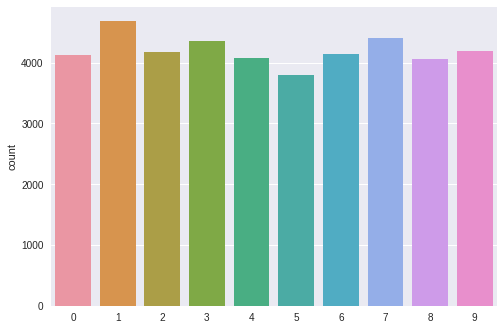

In [15]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import itertools

print(np.max(X), np.mean(X))
#g = sns.countplot(X.flatten())
h = sns.countplot(Y)
# np.histogram(X, bins=np.array(range(256)))

# Initialize parameters

In [0]:
input_size    = 784   # The image size = 28 x 28 = 784
num_classes   = 10    # The number of output classes. In this case, from 0 to 9
num_epochs    = 20     # The number of times entire dataset is trained
train_size = 38000
validation_size = 4000
batch_size    = 64    # The size of input data took for one iteration
learning_rate = 1e-3  # The speed of convergence

# Split into training and validation sets

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
                                                    train_size=train_size,
                                                    test_size=validation_size,
                                                    stratify=Y)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


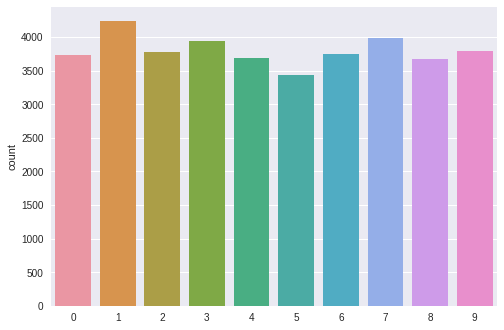

In [12]:
h = sns.countplot(Y_train)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


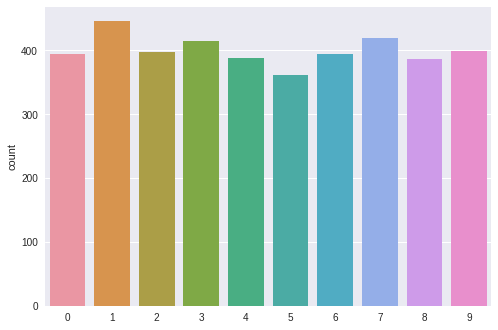

In [13]:
h = sns.countplot(Y_validation)

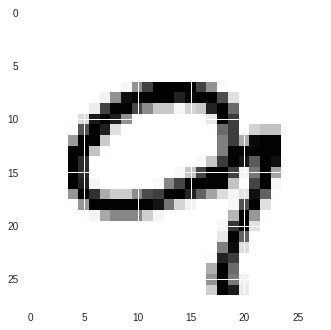

In [19]:
g = plt.imshow(X_train[2][0,:,:])

# Prepare dataset loaders

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class MnistDataset(Dataset):
    def __init__(self, X, Y=None):
        self.X = torch.from_numpy(X / 255.0).float()
        self.Y = None if Y is None else torch.from_numpy(Y).long()
        self.len = len(X)

    def __getitem__(self, i):
        x = self.X[i]
        if self.Y is None:
            return x
        y = self.Y[i]
        return x, y

    def __len__(self):
        return self.len


In [0]:
train_dataset = MnistDataset(X_train, Y_train)
validation_dataset = MnistDataset(X_validation, Y_validation)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True)

validation_loader = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True)

# Download MNIST Dataset from official website
http://yann.lecun.com/exdb/mnist/

In [0]:
# train_dataset = dsets.MNIST(root='./data',
#                            train=True,
#                            transform=transforms.ToTensor(),
#                            download=True)

# test_dataset = dsets.MNIST(root='./data',
#                            train=False,
#                            transform=transforms.ToTensor())

# Load the Dataset

**Note**: We shuffle the loading process of `train_dataset` to make the learning process independent of data order, but the order of `test_loader` remains so as to examine whether we can handle unspecified bias order of inputs.


In [0]:
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,
#                                           shuffle=False)

# Build Neural Network

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def build_cnn():
    return nn.Sequential(
#         nn.BatchNorm2d(1),
        nn.Conv2d(1, 32, 5),
        nn.ReLU(),
        nn.Conv2d(32, 32, 5),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Dropout(0.25),

        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d((2, 2)),
        nn.Dropout(0.25),

        Flatten(),
        nn.Linear(576, 256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, 10),
        nn.Softmax(dim=1))

# Instantiate the CNN

In [0]:
net = build_cnn()
if use_cuda:
  net.cuda()

In [35]:
import torch.nn.init as init

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=init.calculate_gain('relu'))

net.apply(weights_init)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25)
  (12): Flatten()
  (13): Linear(in_features=576, out_features=256, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5)
  (16): Linear(in_features=256, out_features=10, bias=True)
  (17): Softmax()
)

# Choose the Loss Function and Optimizer

Loss function (**criterion**) decides how the output can be compared to a class, which determines how good or bad the neural network performs. And the **optimizer** chooses a way to update the weight in order to converge to find the best weights in this neural network.

In [0]:
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

optimizer = torch.optim.RMSprop(params=net.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5,
                                                    patience=3,
                                                    min_lr=0.00001)

# Training the CNN Model

In [0]:
predicted_train = []
true_train = []
predicted_test = []
true_test = []

def is_last_epoch(epoch):
    return epoch + 1 == num_epochs

In [38]:
!pip install tqdm
from tqdm import tqdm

In [0]:
losses = []

def train_net(epoch):
    net.train()  # set the net to "training mode"
    
    for i, (images, labels) in enumerate(tqdm(train_loader, desc='Epoch #{} - Training'.format(epoch))):   # Load a batch of images with its (index, data, class)
        
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()              # Intialize the hidden weight to all zeros
        outputs = net(images)              # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)  # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                    # Backward pass: compute the weight
        optimizer.step()                   # Optimizer: update the weights of hidden nodes
        
        global losses
        losses.append(loss.item())
    print('Loss: {}'.format(losses[-1]))
#         if (i+1) % 100 == 0:                              # Logging
#             print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
#                  %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

In [0]:
accuracy = []

def validate_net(epoch):
    net.eval()  # set the model to "testing mode" (won't update parameters)

    correct = 0
    total = 0
    for images, labels in tqdm(validation_loader, desc='Epoch #{} - Validation'.format(epoch)):

        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()

        outputs = net(images)
        predicted = outputs.argmax(dim=1)              # Choose the best class from the output: the class with the best score
        total += labels.size(0)                        # Increment the total count
        correct += (predicted == labels).sum().item()  # Increment the correct count
        
        if is_last_epoch(epoch):
            global predicted_test
            global true_test
            true_test += labels.cpu().numpy().tolist()
            predicted_test += predicted.cpu().numpy().tolist()
    
    
    acc = correct / total
    lr_scheduler.step(acc)
    global accuracy
    accuracy.append(acc)
    print('Accuracy: {}'.format(acc))

In [64]:
num_epochs = 50
for epoch in range(num_epochs):
    train_net(epoch)
    validate_net(epoch)

Epoch #0 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.48198401927948


Epoch #1 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #1 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.5236140489578247


Epoch #2 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #2 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4819841384887695


Epoch #3 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #3 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.48198401927948


Epoch #4 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #4 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #5 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #5 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4668253660202026


Epoch #6 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #6 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #7 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #7 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #8 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9895


Epoch #8 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #9 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #9 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4819833040237427


Epoch #10 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99025


Epoch #10 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #11 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #11 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4815115928649902


Epoch #12 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99025


Epoch #12 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4775357246398926


Epoch #13 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #13 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #14 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #14 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #15 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #15 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #16 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #16 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.48198401927948


Epoch #17 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99025


Epoch #17 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #18 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #18 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #19 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #19 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.48198401927948


Epoch #20 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #20 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #21 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99025


Epoch #21 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #22 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #22 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4844870567321777


Epoch #23 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #23 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #24 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #24 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4817180633544922


Epoch #25 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99025


Epoch #25 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4819444417953491


Epoch #26 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #26 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4819811582565308


Epoch #27 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #27 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #28 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #28 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #29 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99025


Epoch #29 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4819871187210083


Epoch #30 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #30 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.481978416442871


Epoch #31 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99025


Epoch #31 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #32 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #32 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.48198401927948


Epoch #33 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #33 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #34 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #34 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.5028172731399536


Epoch #35 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98925


Epoch #35 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.502618432044983


Epoch #36 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9895


Epoch #36 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4969779253005981


Epoch #37 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9895


Epoch #37 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.48198401927948


Epoch #38 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98925


Epoch #38 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4819755554199219


Epoch #39 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9895


Epoch #39 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.502817153930664


Epoch #40 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #40 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4613524675369263


Epoch #41 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9905


Epoch #41 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #42 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #42 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.5028095245361328


Epoch #43 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #43 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4819835424423218


Epoch #44 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.9895


Epoch #44 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #45 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #45 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #46 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #46 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #47 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.98975


Epoch #47 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4616233110427856


Epoch #48 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99


Epoch #48 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.4611506462097168


Epoch #49 - Training:   0%|          | 0/594 [00:00<?, ?it/s]

Accuracy: 0.99025


Epoch #49 - Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Loss: 1.48198401927948


Epoch #49 - Validation: 100%|██████████| 63/63 [00:00<00:00, 103.52it/s]

Accuracy: 0.9905


# Plot the loss and accuracy curves for training and validation 

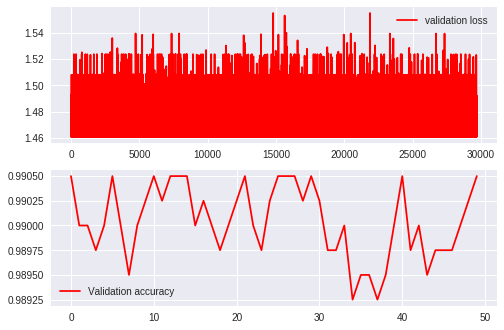

In [65]:

fig, ax = plt.subplots(2,1)
# ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(losses, color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

# ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(accuracy, color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Plot Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues,
                          filesave=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure(figsize=(7, 7))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes)

    yticks = []
    for i in (range(cm.shape[0])):
        acc = cm[i, i] / np.sum(cm[i])
        yticks.append("{} (acc={:.10f})".format(i, acc))

    plt.yticks(tick_marks, yticks)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if filesave is None:
        plt.tight_layout()
#         plt.show()
    else:
        plt.savefig(filesave, bbox_inches='tight')

Confusion matrix, without normalization


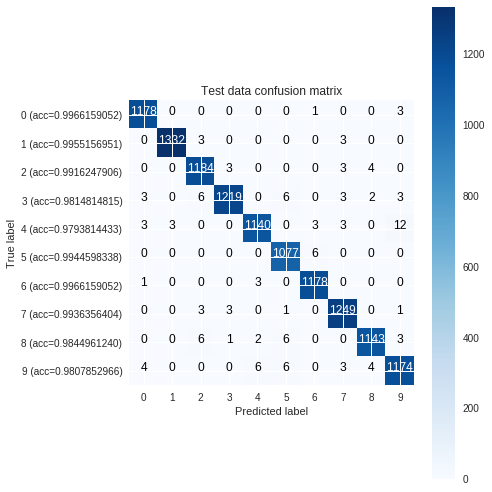

In [67]:
from sklearn.metrics import confusion_matrix

# cnf_matrix = confusion_matrix(true_train, predicted_train)
# plot_confusion_matrix(cm=cnf_matrix, classes=list(range(10)),
#                       title='Train data confusion matrix')

cnf_matrix = confusion_matrix(true_test, predicted_test)
plot_confusion_matrix(cm=cnf_matrix, classes=list(range(10)),
                      title='Test data confusion matrix')

# Kaggle test

In [72]:
X = kaggle_test_file.values
X = X.reshape(-1, 1, 28, 28)
dataset = MnistDataset(X)

test_loader = DataLoader(
    dataset=dataset, batch_size=64, shuffle=False,
    num_workers=4,
    pin_memory=True)

from io import StringIO
file_str = StringIO()

net.eval()

file_str.write('ImageId,Label\n')
img_num = 1
for i, x in enumerate(tqdm(test_loader)):
    if use_cuda:
        x = x.cuda()
    y = net(x).argmax(dim=1)
    for label in y:
      file_str.write('{},{}\n'.format(img_num, int(label)))
      img_num += 1

100%|██████████| 438/438 [00:03<00:00, 132.19it/s]


In [0]:
# Google Drive - create & upload a text file.
uploaded = drive.CreateFile({'title':'kaggle_test.csv', 'mimeType':'text/csv',
        "parents": [{"kind": "drive#fileLink","id": '1b6OdXNGsbLOUFRHczLH6dJtgu5Pwlmcr'}]})
uploaded.SetContentString(file_str.getvalue())
uploaded.Upload()


In [0]:
from google.colab import files

with open('kaggle_test.csv', 'w') as f:
  f.write(file_str.getvalue())

files.download('kaggle_test.csv')

# Testing the CNN Model

Similar to training the neural network, we also need to load batches of test images and collect the outputs. The differences are that:

1. No loss & weights calculation
2. No weights update
3. Has correct prediction calculation


In [0]:
net.eval() 
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    
    if use_cuda and torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    
    
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: %d %%' % (100 * correct / total))

# Save the trained FNN Model for future use

We save the trained model as a pickle that can be loaded and used later.

In [0]:
torch.save(net.state_dict(), 'cnn_model.pkl')